# Pulsar Pyspark
https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star

In [90]:
pip install pyspark

In [91]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pulsar').getOrCreate()

from pyspark.sql.functions import isnan, when, count, col, udf
from pyspark.ml.feature import VectorAssembler, PCA, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [92]:
df_1 = spark.read.csv("pulsar_data_train.csv", header=True, inferSchema=True)
df_2 = spark.read.csv("pulsar_data_test.csv", header=True, inferSchema=True)

In [93]:
df_1.printSchema()

root
 |--  Mean of the integrated profile: double (nullable = true)
 |--  Standard deviation of the integrated profile: double (nullable = true)
 |--  Excess kurtosis of the integrated profile: double (nullable = true)
 |--  Skewness of the integrated profile: double (nullable = true)
 |--  Mean of the DM-SNR curve: double (nullable = true)
 |--  Standard deviation of the DM-SNR curve: double (nullable = true)
 |--  Excess kurtosis of the DM-SNR curve: double (nullable = true)
 |--  Skewness of the DM-SNR curve: double (nullable = true)
 |-- target_class: double (nullable = true)



In [94]:
df_1.head()

Row( Mean of the integrated profile=121.15625,  Standard deviation of the integrated profile=48.37297113,  Excess kurtosis of the integrated profile=0.375484665,  Skewness of the integrated profile=-0.013165488999999999,  Mean of the DM-SNR curve=3.168896321,  Standard deviation of the DM-SNR curve=18.399366600000004,  Excess kurtosis of the DM-SNR curve=7.449874148999999,  Skewness of the DM-SNR curve=65.15929771, target_class=0.0)

In [95]:
df_2.printSchema()

root
 |--  Mean of the integrated profile: double (nullable = true)
 |--  Standard deviation of the integrated profile: double (nullable = true)
 |--  Excess kurtosis of the integrated profile: double (nullable = true)
 |--  Skewness of the integrated profile: double (nullable = true)
 |--  Mean of the DM-SNR curve: double (nullable = true)
 |--  Standard deviation of the DM-SNR curve: double (nullable = true)
 |--  Excess kurtosis of the DM-SNR curve: double (nullable = true)
 |--  Skewness of the DM-SNR curve: double (nullable = true)
 |-- target_class: string (nullable = true)



In [96]:
df_1.head()

Row( Mean of the integrated profile=121.15625,  Standard deviation of the integrated profile=48.37297113,  Excess kurtosis of the integrated profile=0.375484665,  Skewness of the integrated profile=-0.013165488999999999,  Mean of the DM-SNR curve=3.168896321,  Standard deviation of the DM-SNR curve=18.399366600000004,  Excess kurtosis of the DM-SNR curve=7.449874148999999,  Skewness of the DM-SNR curve=65.15929771, target_class=0.0)

In [97]:
print('Train: Rows: {}, Columns: {}'.format(df_1.count(), len(df_1.columns)))
print('Test: Rows: {}, Columns: {}'.format(df_2.count(), len(df_2.columns)))

Train: Rows: 12528, Columns: 9
Test: Rows: 5370, Columns: 9


In [98]:
# Check what kind of values are in the test df in target_class
df_2.groupby('target_class').count().show()

+------------+-----+
|target_class|count|
+------------+-----+
|        null| 5370|
+------------+-----+



In [99]:
# Drop entire target_class column in test df
df_2 = df_2.drop('target_class')

In [100]:
df_2.printSchema()

root
 |--  Mean of the integrated profile: double (nullable = true)
 |--  Standard deviation of the integrated profile: double (nullable = true)
 |--  Excess kurtosis of the integrated profile: double (nullable = true)
 |--  Skewness of the integrated profile: double (nullable = true)
 |--  Mean of the DM-SNR curve: double (nullable = true)
 |--  Standard deviation of the DM-SNR curve: double (nullable = true)
 |--  Excess kurtosis of the DM-SNR curve: double (nullable = true)
 |--  Skewness of the DM-SNR curve: double (nullable = true)



In [101]:
# Check NaN or Null values in train df
df_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_1.columns]).show()

+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+------------+
| Mean of the integrated profile| Standard deviation of the integrated profile| Excess kurtosis of the integrated profile| Skewness of the integrated profile| Mean of the DM-SNR curve| Standard deviation of the DM-SNR curve| Excess kurtosis of the DM-SNR curve| Skewness of the DM-SNR curve|target_class|
+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+------------+
|                              0|                                            0|      

In [102]:
# Check NaN or Null values in test df
df_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_2.columns]).show()

+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+
| Mean of the integrated profile| Standard deviation of the integrated profile| Excess kurtosis of the integrated profile| Skewness of the integrated profile| Mean of the DM-SNR curve| Standard deviation of the DM-SNR curve| Excess kurtosis of the DM-SNR curve| Skewness of the DM-SNR curve|
+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+
|                              0|                                            0|                                       767|  

In [103]:
# Drop entire rows containing na values
df_1 = df_1.na.drop()
df_2 = df_2.na.drop()

# Check number of remaining data
print('Train: Rows: {}, Columns: {}'.format(df_1.count(), len(df_1.columns)))
print('Test: Rows: {}, Columns: {}'.format(df_2.count(), len(df_2.columns)))

Train: Rows: 9273, Columns: 9
Test: Rows: 3985, Columns: 8


In [104]:
# Display of df train in pandas format
df_1.limit(5).toPandas()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0
4,109.406250,55.912521,0.565106,0.056247,2.797659,19.496527,9.443282,97.374578,0.0


In [105]:
# Show stats on 2 columns
df_1.select(' Mean of the integrated profile', ' Standard deviation of the integrated profile').summary().show()

+-------+-------------------------------+---------------------------------------------+
|summary| Mean of the integrated profile| Standard deviation of the integrated profile|
+-------+-------------------------------+---------------------------------------------+
|  count|                           9273|                                         9273|
|   mean|             111.13375020219993|                           46.514052911853746|
| stddev|              25.68640537915268|                            6.781319578562155|
|    min|                         6.1875|                                  24.77204176|
|    25%|                     100.984375|                                  42.39838208|
|    50%|                     115.234375|                                  46.89502632|
|    75%|                     189.734375|                                   91.8086279|
|    max|                     189.734375|                                   91.8086279|
+-------+-----------------------

In [106]:
# Number of element in each class
df_1.groupBy('target_class').count().show()

+------------+-----+
|target_class|count|
+------------+-----+
|         0.0| 8423|
|         1.0|  850|
+------------+-----+



In [107]:
# Mean of 2 features grouped by class
df_1.groupBy('target_class').mean(' Mean of the integrated profile', ' Mean of the DM-SNR curve').show()

+------------+------------------------------------+------------------------------+
|target_class|avg( Mean of the integrated profile)|avg( Mean of the DM-SNR curve)|
+------------+------------------------------------+------------------------------+
|         0.0|                  116.64799878309391|             8.886565869002865|
|         1.0|                   56.49079044117647|            50.874638009127025|
+------------+------------------------------------+------------------------------+



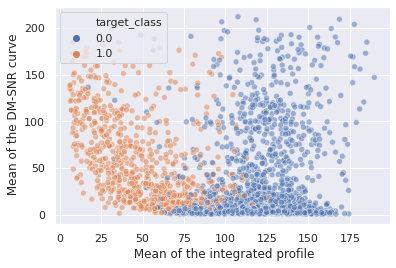

In [108]:
extract_to_plot = df_1.select(' Mean of the integrated profile', ' Mean of the DM-SNR curve', 'target_class').toPandas()
sns.scatterplot(data=extract_to_plot, x=' Mean of the integrated profile', y=' Mean of the DM-SNR curve', hue='target_class', alpha = 0.5)

In [109]:
# Add a literate target name (just to experiment udf)
litterate_target = udf(lambda x: 'pulsar' if x == 1 else 'not_pulsar')
df_1 = df_1.withColumn('literate_target', litterate_target('target_class'))
df_1.show(5)

+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+------------+---------------+
| Mean of the integrated profile| Standard deviation of the integrated profile| Excess kurtosis of the integrated profile| Skewness of the integrated profile| Mean of the DM-SNR curve| Standard deviation of the DM-SNR curve| Excess kurtosis of the DM-SNR curve| Skewness of the DM-SNR curve|target_class|literate_target|
+-------------------------------+---------------------------------------------+------------------------------------------+-----------------------------------+-------------------------+---------------------------------------+------------------------------------+-----------------------------+------------+---------------+
|                      121.15625|    

In [110]:
# find features columns in train df (without target_class and literate_target)
df_1.columns[:-2]

[' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve']

In [111]:
# Check columns in test df
df_2.columns[:]

[' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve']

In [112]:
# Build assembler (all features for each df line must be in a vector appearing in 1 column)
# The result of the assembler lies in a new output column
# The assembler will be called in the ML pipeline
assembler = VectorAssembler(inputCols=df_1.columns[:-2], outputCol='features')
assembler.transform(df_1).select('features','target_class').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                              |target_class|
+----------------------------------------------------------------------------------------------------------------------+------------+
|[121.15625,48.37297113,0.375484665,-0.013165488999999999,3.168896321,18.399366600000004,7.449874148999999,65.15929771]|0.0         |
|[76.96875,36.17555664,0.71289786,3.3887185630000003,2.399665552,17.57099693,9.414652256,102.7229747]                  |0.0         |
|[130.5859375,53.22953353,0.133408289,-0.297241641,2.743311037,22.36255299,8.508363784,74.03132420000001]              |0.0         |
|[84.8046875,36.11765898,0.825012787,3.274125373,2.7901337789999996,20.61800857,8.405008383,76.29112787]               |0.0         |
|[109.40625,55.91252061,0.565105947,0.056246664,2.797658863,19

In [113]:
# Evaluator precises the target column and the kind of metrics to use 
evaluator = MulticlassClassificationEvaluator(labelCol='target_class', metricName='f1')

In [114]:
# Split train set to a ml train set and a validation set
df_train, df_test = df_1.randomSplit([0.8, 0.2], seed=42)

In [119]:
# Define transformtions stages to throw in the pipeline
assembler = VectorAssembler(inputCols=df_1.columns[:-2], outputCol='features')
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
pca = PCA(inputCol="scaledFeatures", outputCol="pcaFeatures")
lsvc = LinearSVC(labelCol='target_class')

# Definition of pipeline
pipeline_lsvc = Pipeline(stages=[assembler, scaler, pca, lsvc])

# Definition of the grid parameters
paramGrid = ParamGridBuilder().\
            addGrid(pca.k, [2,5]).\
            addGrid(lsvc.maxIter, [10,100]).\
            addGrid(lsvc.regParam, [0.1,0.01]).\
            build()

# Definition of the cross validator
cv = CrossValidator(
  estimator=pipeline_lsvc,
  estimatorParamMaps=paramGrid, 
  evaluator=evaluator, 
  numFolds=5)

# Train the model
model_final = cv.fit(df_train)

# Predict classes on test part
pred_ml_test = model_final.transform(df_test)
evaluator.evaluate(pred_ml_test)

0.9729483801626402

In [120]:
pred_train_pd = pred_ml_test.toPandas()
print(classification_report(pred_train_pd.prediction, pred_train_pd.target_class))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1682
         1.0       0.70      0.96      0.81       101

    accuracy                           0.97      1783
   macro avg       0.85      0.97      0.90      1783
weighted avg       0.98      0.97      0.98      1783



In [117]:
pred_test = model_final.transform(df_2)
pred_test.printSchema()

root
 |--  Mean of the integrated profile: double (nullable = true)
 |--  Standard deviation of the integrated profile: double (nullable = true)
 |--  Excess kurtosis of the integrated profile: double (nullable = true)
 |--  Skewness of the integrated profile: double (nullable = true)
 |--  Mean of the DM-SNR curve: double (nullable = true)
 |--  Standard deviation of the DM-SNR curve: double (nullable = true)
 |--  Excess kurtosis of the DM-SNR curve: double (nullable = true)
 |--  Skewness of the DM-SNR curve: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- pcaFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [118]:
pred_test = pred_test.withColumn('literate_target', litterate_target('prediction'))
pred_test.select('literate_target').show(10, truncate=False)

+---------------+
|literate_target|
+---------------+
|not_pulsar     |
|pulsar         |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
|not_pulsar     |
+---------------+
only showing top 10 rows

